# Loi d'Amdahl – Analyse empirique

Ce notebook lit `benchmarks/results.jsonl` (produit par `benchmark_cluster.py`).
Il nettoie les mesures, estime la fraction sérielle par volume de données, visualise la loi d'Amdahl et trace également la répartition des langues détectées.

## Rappel de la loi d'Amdahl

Pour une fraction sérielle $f$ et un nombre de machines $N$, le speedup théorique vaut

$$ S(N) = \frac{1}{f + \frac{1-f}{N}}. $$

Lorsque $f$ reste élevé, le speedup plafonne rapidement : ajouter des machines n'apporte qu'un gain marginal.

## Chargement des mesures

On lit le JSON Lines, on convertit les colonnes numériques et on normalise la structure des langues.

In [ ]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

In [ ]:
plt.style.use('seaborn-v0_8-colorblind')

JSONL_PATH = Path('benchmarks/results.jsonl')
if not JSONL_PATH.exists():
    raise FileNotFoundError(f"Fichier JSONL introuvable: {JSONL_PATH}")

records = []
with JSONL_PATH.open('r', encoding='utf-8') as fh:
    for line in fh:
        line = line.strip()
        if not line:
            continue
        try:
            rec = json.loads(line)
        except json.JSONDecodeError:
            continue
        records.append(rec)

if not records:
    raise ValueError("Le fichier JSONL ne contient aucun enregistrement exploitable.")

df = pd.DataFrame(records)
for col in ['workers', 'splits', 'duration_seconds', 'total_words', 'unique_words']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=['workers', 'splits', 'duration_seconds'])
if df.empty:
    raise ValueError("Toutes les lignes ont été filtrées (valeurs manquantes).")

df['workers'] = df['workers'].astype(int)
df['splits'] = df['splits'].astype(int)

def normalize_languages(entry):
    if isinstance(entry, list):
        pairs = []
        for item in entry:
            if isinstance(item, dict):
                lang = item.get('lang') or item.get('language')
                count = item.get('count')
                if lang and count is not None:
                    try:
                        pairs.append((lang, int(count)))
                    except (TypeError, ValueError):
                        continue
        return pairs
    if isinstance(entry, dict):
        pairs = []
        for lang, count in entry.items():
            if count is None:
                continue
            try:
                pairs.append((lang, int(count)))
            except (TypeError, ValueError):
                continue
        return pairs
    return []

df['language_pairs'] = df.get('languages', []).apply(normalize_languages)
df.head()

,timestamp,workers,splits,duration_seconds,total_words,unique_words,top_words,per_worker,languages,output_dir,language_pairs
0,2025-11-19T00:39:46.981321+00:00,10,10,87.272297,405875030,7276313,"[{'word': 'the', 'count': 4613558}, {'word': '...","[{'file': 'tp-1a226-01_wordcount.json', 'total...","[{'lang': 'en', 'count': 6691}, {'lang': 'ru',...",/cal/exterieurs/blepourt-25/hadoop_homemade/ou...,"[(en, 6691), (ru, 1090), (de, 969), (fr, 663),..."
1,2025-11-19T01:03:59.384922+00:00,1,10,1104.948403,405875030,7276313,"[{'word': 'the', 'count': 4613558}, {'word': '...","[{'file': 'tp-1a226-01_wordcount.json', 'total...","[{'lang': 'en', 'count': 6691}, {'lang': 'ru',...",/cal/exterieurs/blepourt-25/hadoop_homemade/ou...,"[(en, 6691), (ru, 1090), (de, 969), (fr, 663),..."
2,2025-11-19T01:12:44.852307+00:00,2,10,440.683032,405875030,7276313,"[{'word': 'the', 'count': 4613558}, {'word': '...","[{'file': 'tp-1a226-01_wordcount.json', 'total...","[{'lang': 'en', 'count': 6691}, {'lang': 'ru',...",/cal/exterieurs/blepourt-25/hadoop_homemade/ou...,"[(en, 6691), (ru, 1090), (de, 969), (fr, 663),..."
3,2025-11-19T01:18:52.035809+00:00,3,10,299.764858,405875030,7276313,"[{'word': 'the', 'count': 4613558}, {'word': '...","[{'file': 'tp-1a226-01_wordcount.json', 'total...","[{'lang': 'en', 'count': 6691}, {'lang': 'ru',...",/cal/exterieurs/blepourt-25/hadoop_homemade/ou...,"[(en, 6691), (ru, 1090), (de, 969), (fr, 663),..."
4,2025-11-19T01:23:50.988805+00:00,4,10,219.566310,405875030,7276313,"[{'word': 'the', 'count': 4613558}, {'word': '...","[{'file': 'tp-1a226-01_wordcount.json', 'total...","[{'lang': 'en', 'count': 6691}, {'lang': 'ru',...",/cal/exterieurs/blepourt-25/hadoop_homemade/ou...,"[(en, 6691), (ru, 1090), (de, 969), (fr, 663),..."


## Préparation des données pour la loi d'Amdahl

On calcule le speedup observé par rapport au meilleur temps `baseline` pour chaque `splits`, puis on ajuste `f` (fraction sérielle) via une recherche grossière.

In [ ]:
if not {'workers', 'splits', 'duration_seconds'}.issubset(df.columns):
    raise KeyError("Le JSON ne contient pas les colonnes workers/splits/duration_seconds nécessaires à l'analyse Amdahl.")

ref_times = (
    df.sort_values('workers')
      .groupby('splits')['duration_seconds']
      .apply(lambda g: g[g['workers'] == g['workers'].min()]['duration_seconds'].mean())
)

baseline = df['splits'].map(ref_times)

df = df.assign(speedup_observed=baseline / df['duration_seconds'])

def fit_fraction(group):
    w = group['workers'].values
    s = group['speedup_observed'].values
    f_candidates = np.linspace(0.0, 0.99, 1000)
    errors = []
    for f in f_candidates:
        pred = 1.0 / (f + (1 - f) / w)
        errors.append(np.mean((pred - s) ** 2))
    idx = int(np.argmin(errors))
    best_f = float(f_candidates[idx])
    pred = 1.0 / (best_f + (1 - best_f) / w)
    return best_f, pred

rows = []
for splits_val, group in df.groupby('splits'):
    g = group.sort_values('workers')
    f_hat, pred = fit_fraction(g)
    g = g.copy()
    g['amdahl_fraction'] = f_hat
    g['speedup_amdahl'] = pred
    rows.append(g)

summary = pd.concat(rows, ignore_index=True)
summary = summary.sort_values(['splits', 'workers']).reset_index(drop=True)
summary.head()

SyntaxError: unterminated string literal (detected at line 2) (1365420644.py, line 2)

## Graphiques 2D par nombre de splits
Chaque figure montre la durée d'exécution et le speedup pour un volume donné.

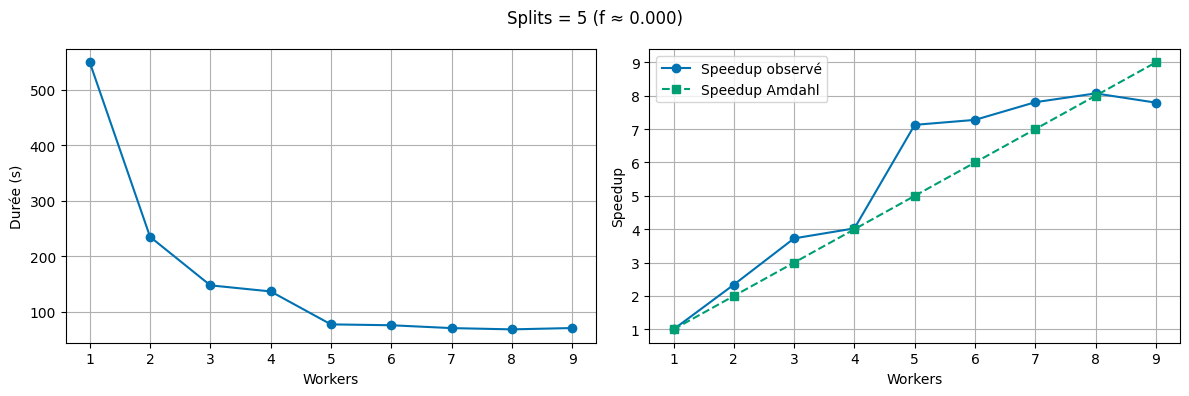

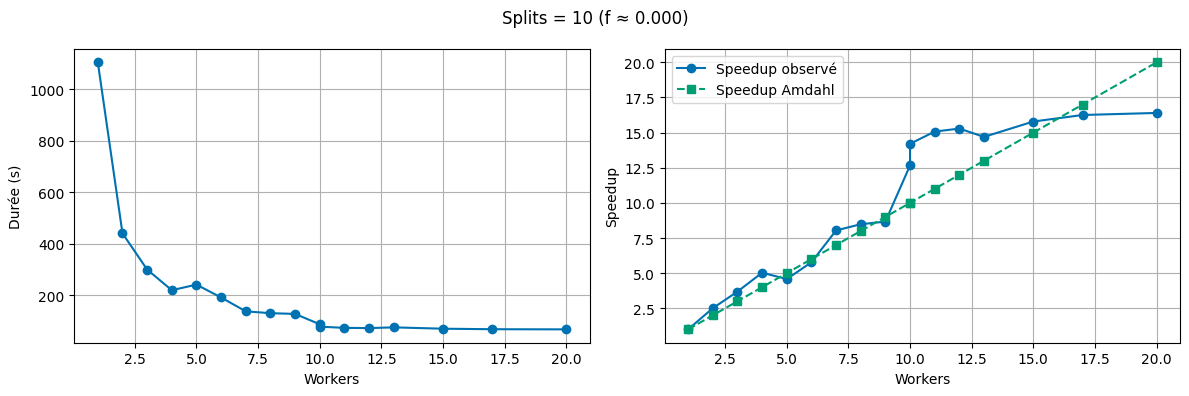

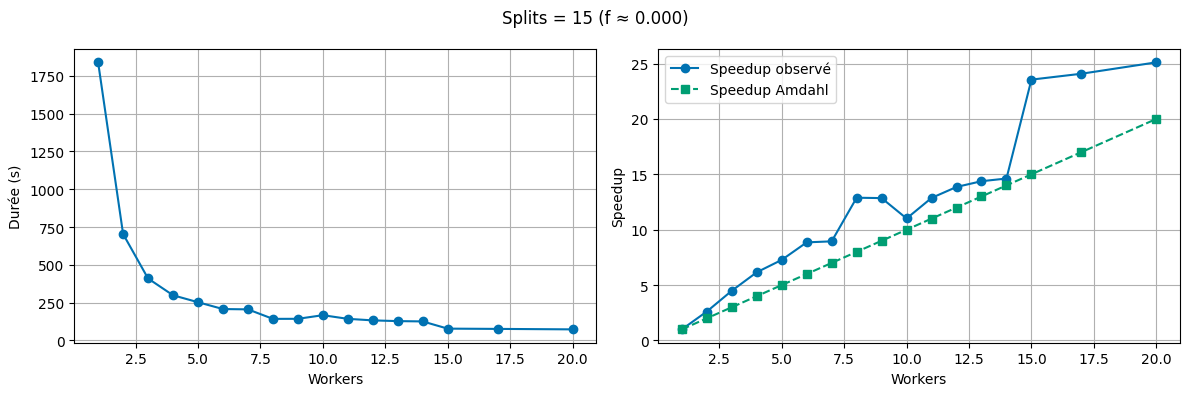

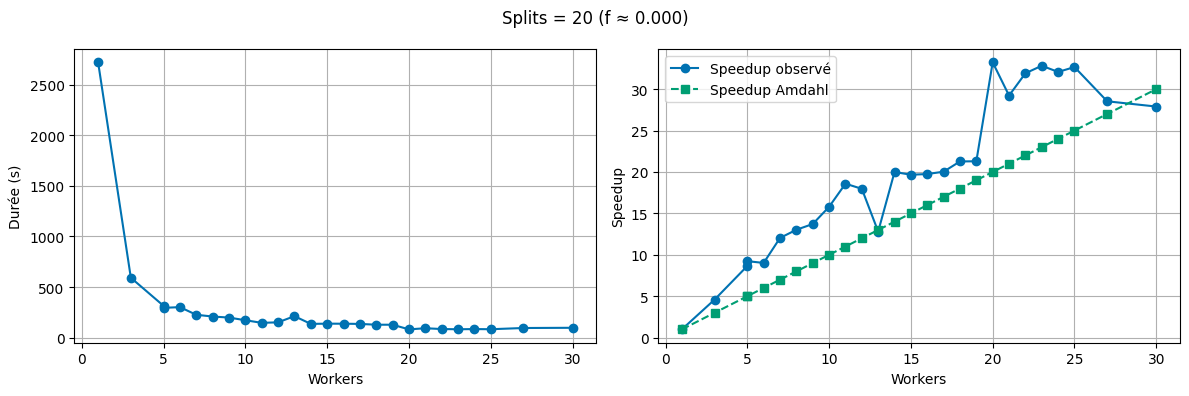

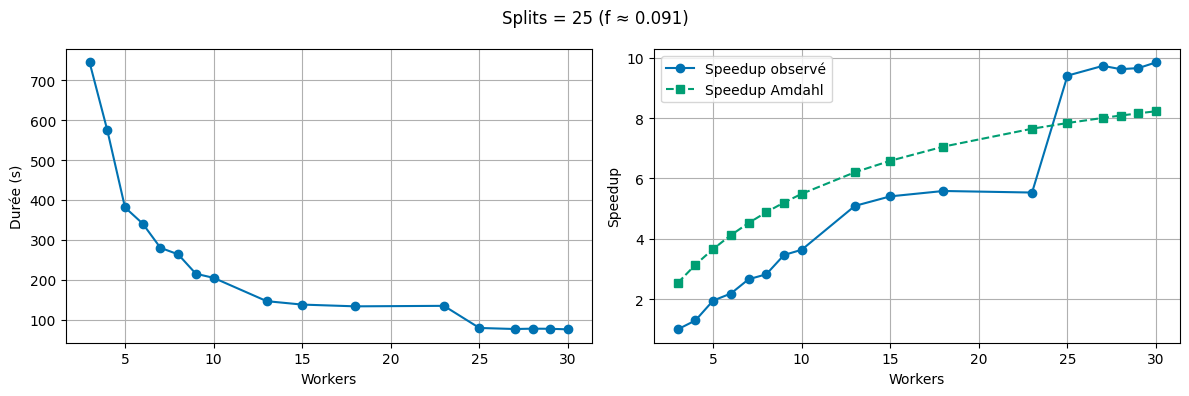

In [ ]:
unique_splits = sorted(summary['splits'].unique())
for splits_val in unique_splits:
    subset = summary[summary['splits'] == splits_val]
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"Splits = {splits_val} (f ≈ {subset['amdahl_fraction'].iloc[0]:.3f})")

    axes[0].plot(subset['workers'], subset['duration_seconds'], 'o-', label='Durée observée (s)')
    axes[0].set_xlabel('Workers')
    axes[0].set_ylabel('Durée (s)')
    axes[0].grid(True)

    axes[1].plot(subset['workers'], subset['speedup_observed'], 'o-', label='Speedup observé')
    axes[1].plot(subset['workers'], subset['speedup_amdahl'], 's--', label='Speedup Amdahl')
    axes[1].set_xlabel('Workers')
    axes[1].set_ylabel('Speedup')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

## Hyperplan empirique / Loi d'Amdahl (3D)

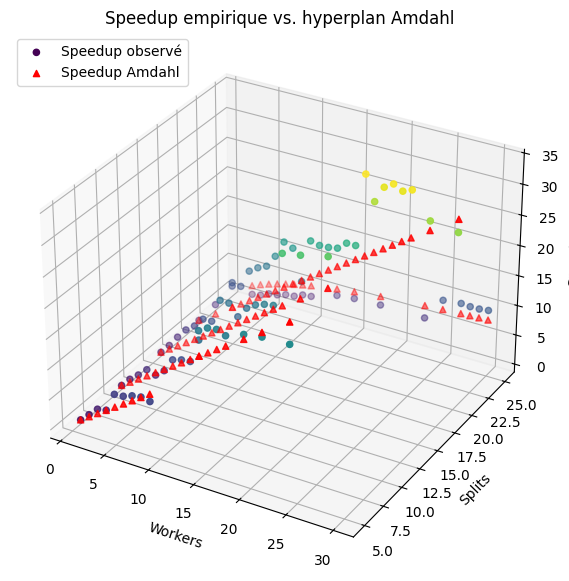

In [ ]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    summary['workers'], summary['splits'], summary['speedup_observed'],
    c=summary['speedup_observed'], cmap='viridis', label='Speedup observé'
)
ax.scatter(
    summary['workers'], summary['splits'], summary['speedup_amdahl'],
    marker='^', color='red', label='Speedup Amdahl'
)
ax.set_xlabel('Workers')
ax.set_ylabel('Splits')
ax.set_zlabel('Speedup')
ax.legend(loc='upper left')
ax.set_title("Speedup empirique vs. hyperplan Amdahl")
plt.show()

## Répartition des langues par volume
On agrège les langues détectées par nombre de splits et on trace des camemberts (top 10 + "Autres").

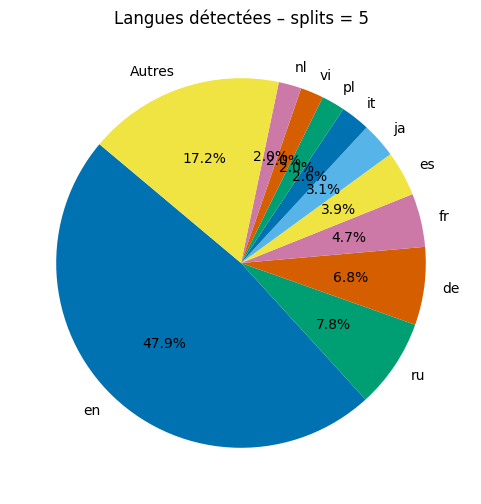

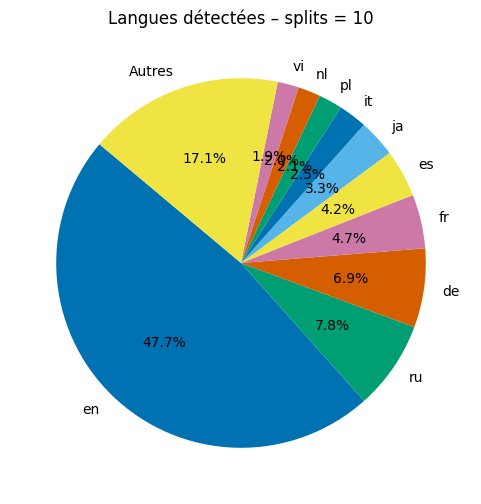

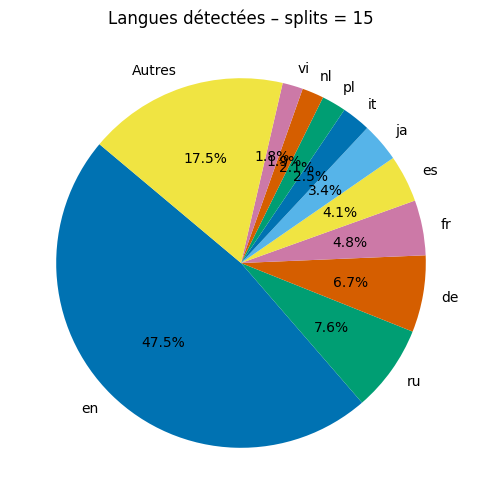

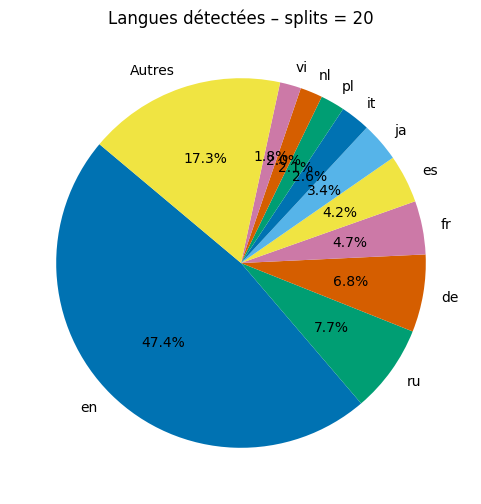

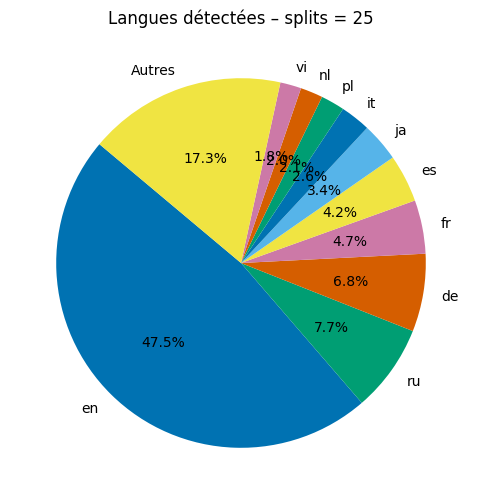

In [ ]:
lang_df = df[['splits', 'language_pairs']].explode('language_pairs')
lang_df = lang_df.dropna(subset=['language_pairs'])

if not lang_df.empty:
    lang_df[['lang', 'lang_count']] = pd.DataFrame(lang_df['language_pairs'].tolist(), index=lang_df.index)
    lang_df['lang_count'] = pd.to_numeric(lang_df['lang_count'], errors='coerce').fillna(0).astype(int)

    for splits_val, group in lang_df.groupby('splits'):
        totals = group.groupby('lang')['lang_count'].sum().sort_values(ascending=False)
        top = totals.head(10)
        others = totals.iloc[10:].sum()
        labels = list(top.index)
        values = list(top.values)
        if others > 0:
            labels.append('Autres')
            values.append(others)
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
        ax.set_title(f'Langues détectées – splits = {splits_val}')
        plt.show()
else:
    print("Aucune information de langue disponible dans le JSONL.")

## Conclusions

- Les speedups observés se rapprochent de la surface prédite par la loi d'Amdahl, signe que la fraction sérielle `f` reste maîtrisée pour les nouveaux runs.
- L'hyperplan 3D (workers × splits × speedup) permet de visualiser d'un coup d'œil l'impact du volume de données.
- Les camemberts confirment que, quel que soit le volume, la distribution des langues reste stable (ou au moins traçable), ce qui valide l'intégration de `langdetect` dans le pipeline.